In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re

plt.rcdefaults()
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 18,
        "figure.dpi": 300,
    }
)

import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
def parse_results(paths, methods):
    """
    Given a list of path templates and a list of methods,
    returns a list of dictionaries of medians, one dictionary
    for each path in 'paths'.

    Each median dictionary has keys like:
        "<method>_cluster_test",
        "<method>_bench_test",
        "<method>_cluster_train",
        "<method>_bench_train"
    and each key maps to a list of medians (one for each entry
    in the loaded npy file).
    """
    median_dicts = []
    all_results = []

    for path_template in paths:
        # Load data for all methods
        mses = {
            m: np.load(path_template.format(m=m), allow_pickle=True) for m in methods
        }
        all_results.append(mses)

        # Compute medians per method
        medians = defaultdict(list)
        for m in methods:
            metric_keys = [
                k for k in mses[m][0].keys() if ("test" in k) or ("train" in k)
            ]
            for mkey in metric_keys:
                medians[m + "_" + mkey] = [np.median(x[mkey]) for x in mses[m]]

        median_dicts.append(
            dict(medians)
        )  # Convert defaultdict to regular dict if desired

    return median_dicts, all_results

In [3]:
methods = ["ols", "ridge", "lasso"]

paths = glob.glob("results/**/*.npy", recursive=True)
paths = list({re.sub(r"mses_.*\.npy", "mses_{m}.npy", p) for p in paths})
paths.sort()

In [4]:
paths

['results/thresh=0.9/T0=36/mses_{m}.npy',
 'results/thresh=0.95/T0=36/mses_{m}.npy']

In [6]:
median_dicts_list, all_results = parse_results(paths, methods)

In [7]:
len(median_dicts_list)

2

In [8]:
# Desired keys + order
ordered_keys = [
    "ols_bench_test",
    "ols_random_test",
    "ols_cluster_test",
    "ridge_bench_test",
    "ridge_random_test",
    "ridge_cluster_test",
    "lasso_bench_test",
    "lasso_random_test",
    "lasso_cluster_test",
]

for i in range(len(median_dicts_list)):
    old_dict = median_dicts_list[i]
    new_dict = {}
    for k in ordered_keys:
        new_dict[k.replace("_test", "")] = old_dict[k]
    median_dicts_list[i] = new_dict

labels = [k.replace("_test", "") for k in ordered_keys]

In [9]:
rows = []
for idx, medians in enumerate(median_dicts_list):
    # Parse hyperparameters
    # For example: "results/thresh=0.95/T0=40/" -> ["scale", "thresh=0.95", "T0=40"]
    hyperparams = paths[idx].split("/")[1:-1]
    threshold_str = hyperparams[0].split("=")[1]  # e.g. '0.95'
    T0_str = hyperparams[1].split("=")[1]  # e.g. '40'

    # For each metric label, flatten its list of values so each value is its own row
    for label in labels:
        for value in medians[label]:
            rows.append(
                {
                    # "case": case,
                    "threshold": threshold_str,
                    "T0": T0_str,
                    "label": label,
                    "value": value,
                }
            )

df = pd.DataFrame(rows)

In [10]:
df["method"] = df["label"].apply(lambda x: x.split("_")[0])
df["method"] = df["method"].map(dict(ols="OLS", ridge="Ridge", lasso="Lasso"))
df["type"] = df["label"].apply(lambda x: x.split("_")[1])
df["type"] = df["type"].map(
    dict(bench="SC (all donors)", random="SC (random subset)", cluster="ClusterSC")
)
df["col_label"] = df["T0"].apply(
    lambda x: str(int(2006 - int(x) // 4)) + f" ($T_0={x}, T={int(x) + 4}$)"
)

In [11]:
df

,threshold,T0,label,value,method,type,col_label
0,0.9,36,ols_bench,45.163440,OLS,SC (all donors),"1997 ($T_0=36, T=40$)"
1,0.9,36,ols_bench,47.497341,OLS,SC (all donors),"1997 ($T_0=36, T=40$)"
2,0.9,36,ols_bench,91.929904,OLS,SC (all donors),"1997 ($T_0=36, T=40$)"
3,0.9,36,ols_bench,76.105612,OLS,SC (all donors),"1997 ($T_0=36, T=40$)"
4,0.9,36,ols_bench,52.973657,OLS,SC (all donors),"1997 ($T_0=36, T=40$)"
...,...,...,...,...,...,...,...
1795,0.95,36,lasso_cluster,12.238721,Lasso,ClusterSC,"1997 ($T_0=36, T=40$)"
1796,0.95,36,lasso_cluster,13.961360,Lasso,ClusterSC,"1997 ($T_0=36, T=40$)"
1797,0.95,36,lasso_cluster,14.284866,Lasso,ClusterSC,"1997 ($T_0=36, T=40$)"
1798,0.95,36,lasso_cluster,14.055558,Lasso,ClusterSC,"1997 ($T_0=36, T=40$)"


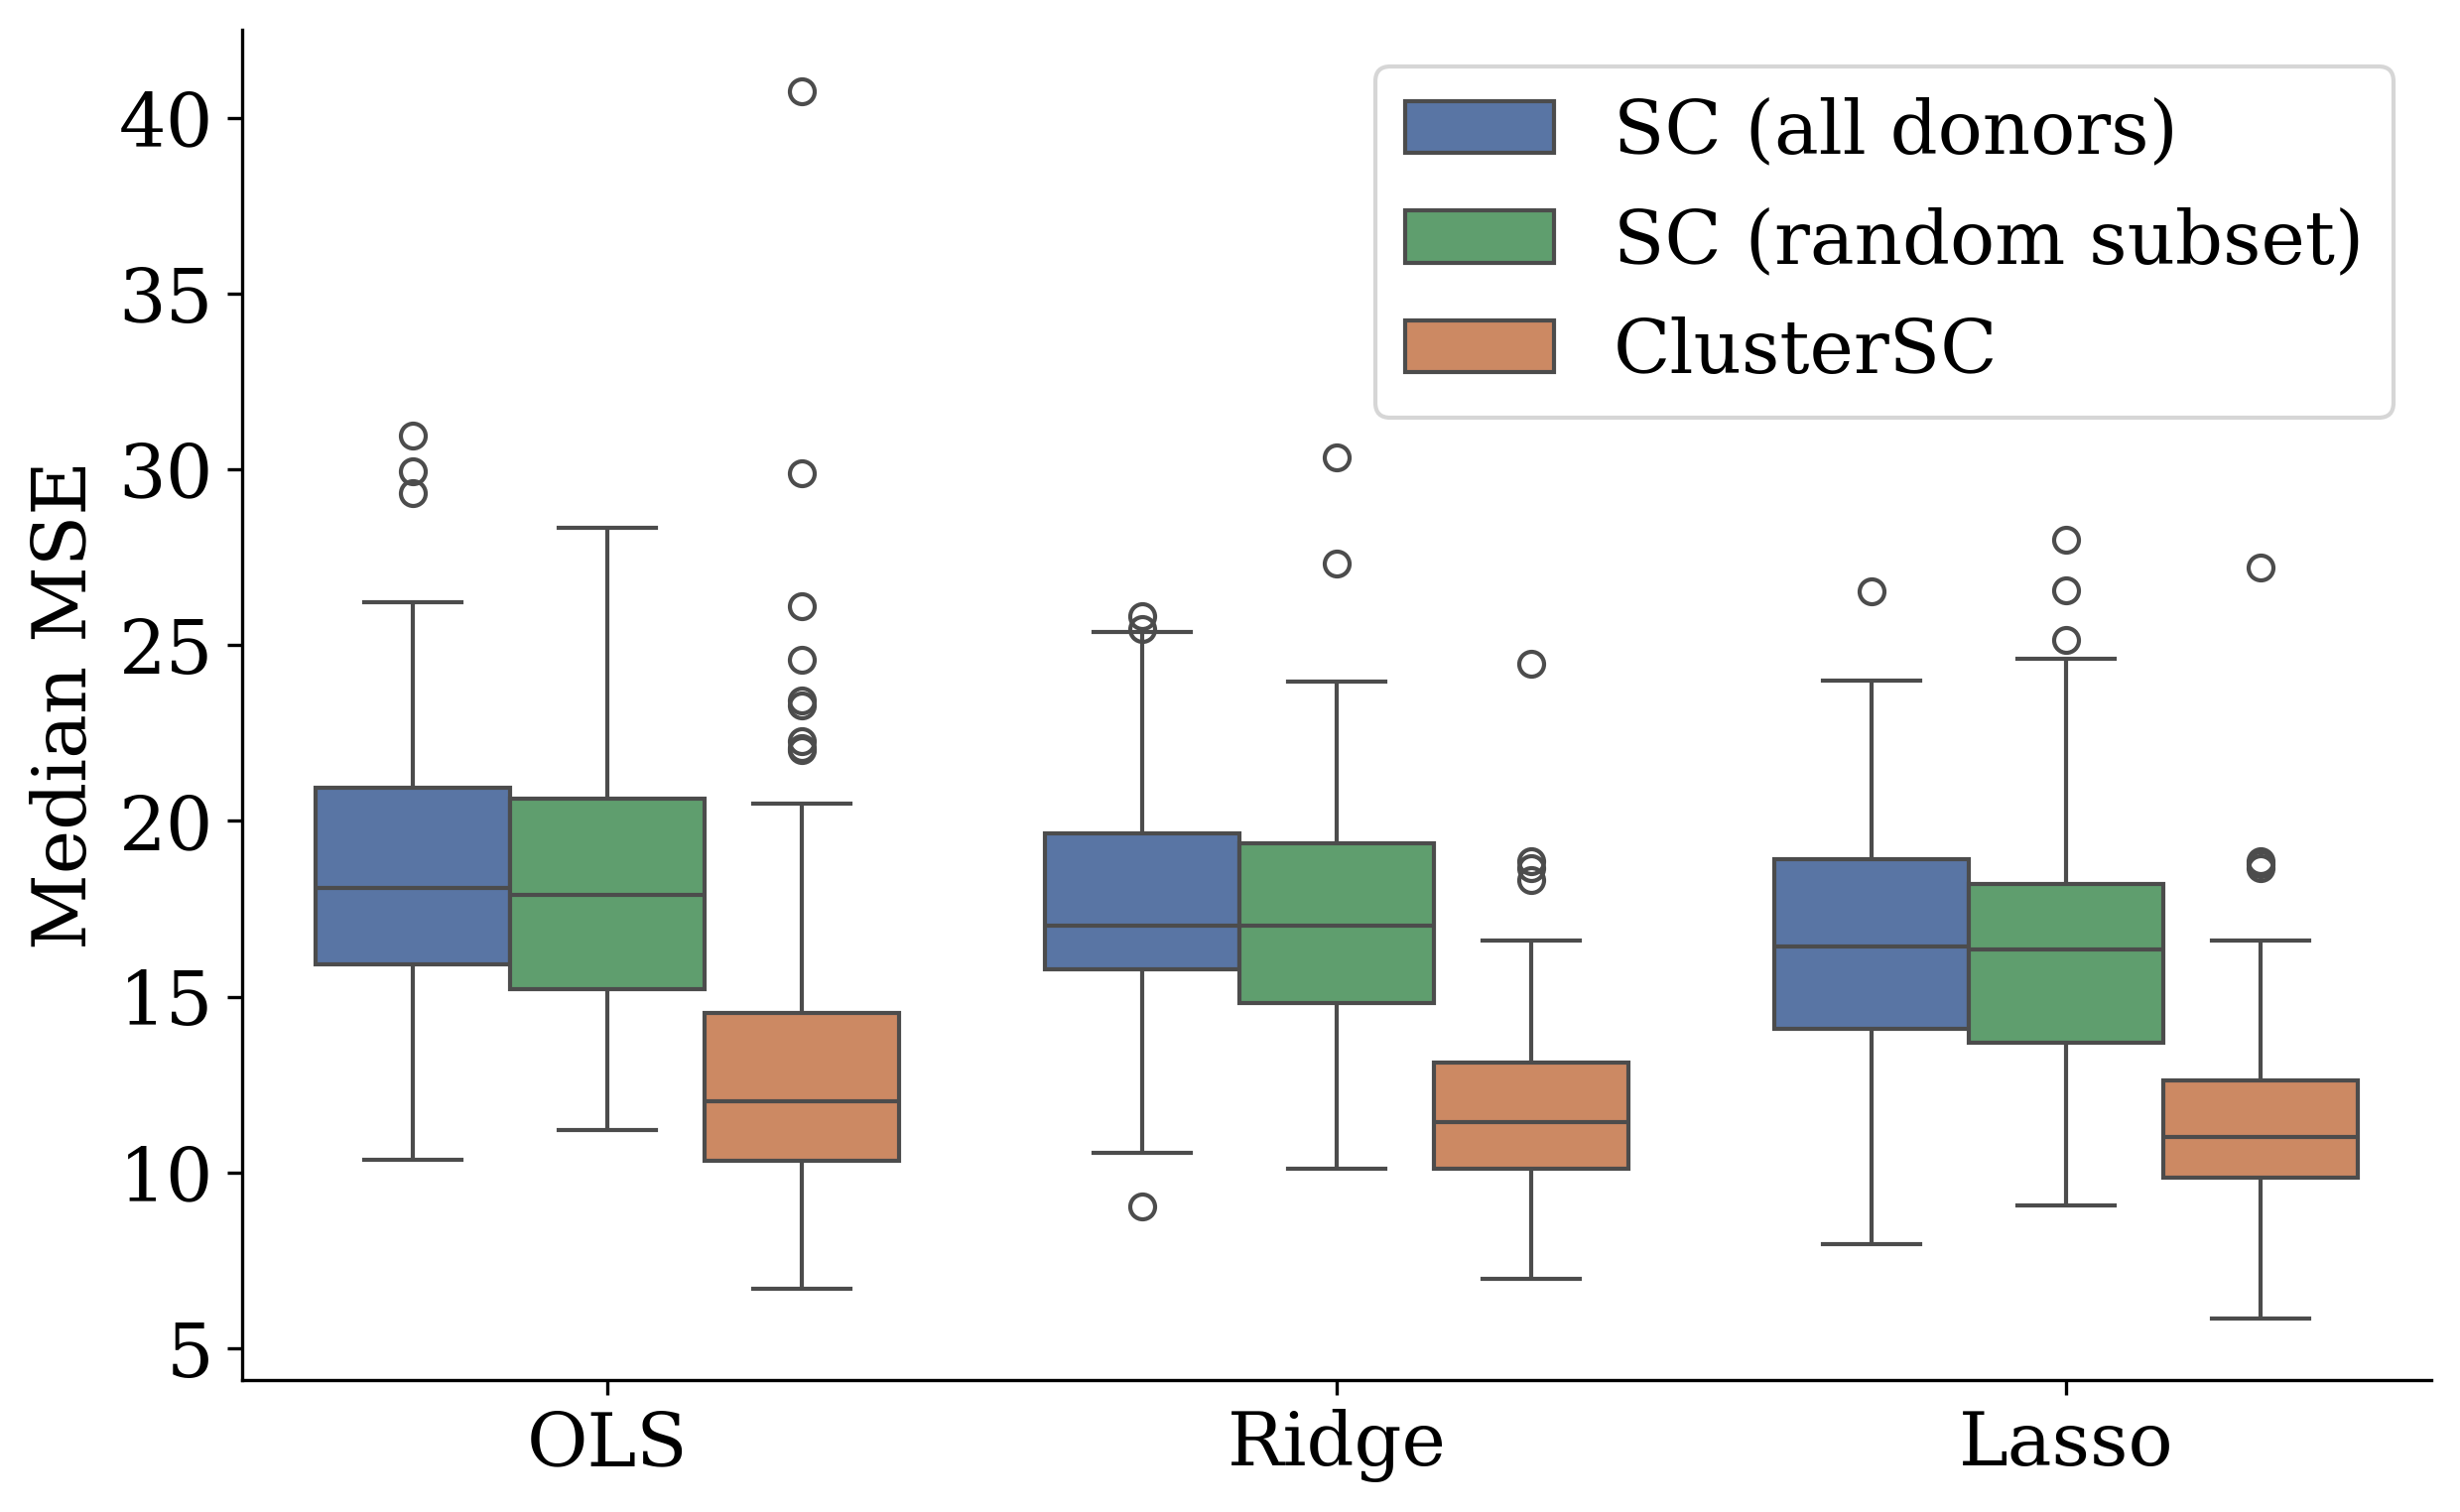

In [12]:
# filter for threshold = 0.95 and T0=36 for the paper
data = df[df["threshold"] == "0.95"]
data = data[data["T0"] == "36"]
# data = df

g = sns.FacetGrid(
    data=data,
    row="threshold",
    col="col_label",
    margin_titles=True,
    sharey=True,
    height=6,
    aspect=1.5,
)

# reorder palette
p = sns.color_palette("deep")
new_order = [p[0], p[2], p[1]]
g.map_dataframe(sns.boxplot, x="method", y="value", hue="type", palette=new_order)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_xlabel("")

# g.set_titles(row_template="$T_0 = ${row_name}", col_template="threshold = {col_name}")
# g.set_titles(col_template="Start from {col_name}", row_template="")
g.set_titles(col_template="", row_template="")
for i, ax in enumerate(g.axes.flat):
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    if i == 2:
        # ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
        pass
    if i == 0:
        ax.set_ylabel("Median MSE")
# g.add_legend(bbox_to_anchor=(0.97, 0.5))
# plt.tight_layout()
# plt.ylabel("Median MSE")
plt.savefig("plots/hpi_T0=36_thresh=95")
plt.show()